# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [3]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [4]:
data = np.load("mars_for_students_cleaned.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 100

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [6]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [7]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [9]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [10]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [11]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label


In [12]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
      ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...


<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'mask_fill_value' is no

WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


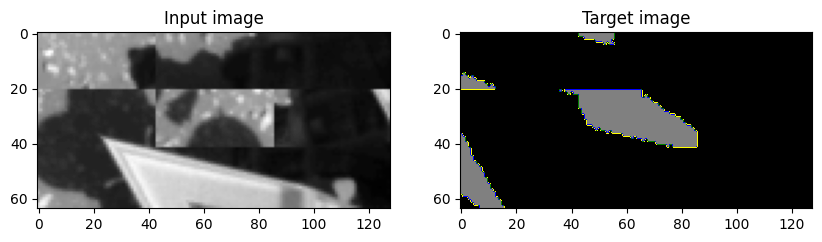

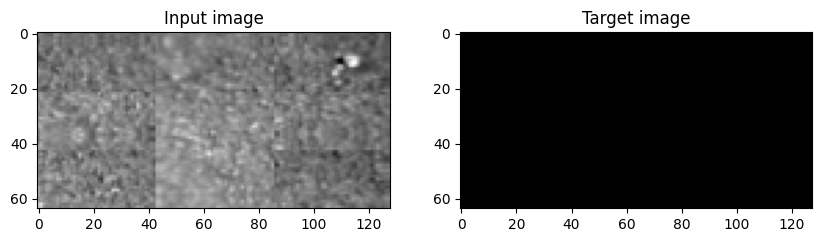

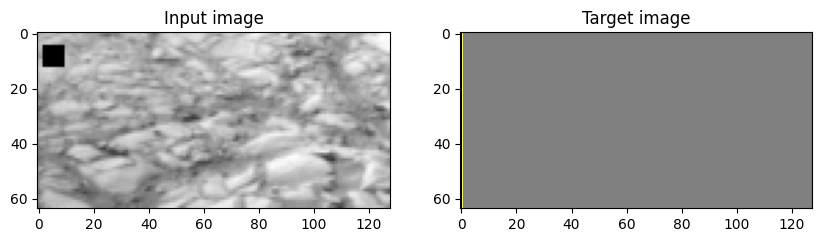

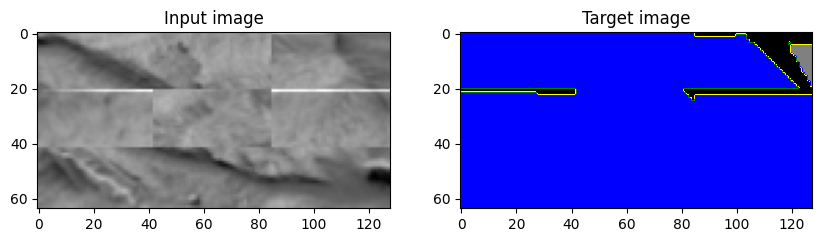

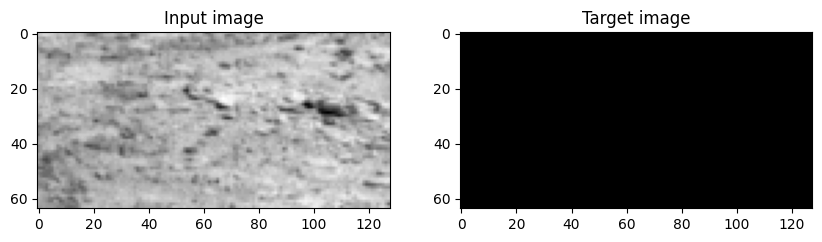

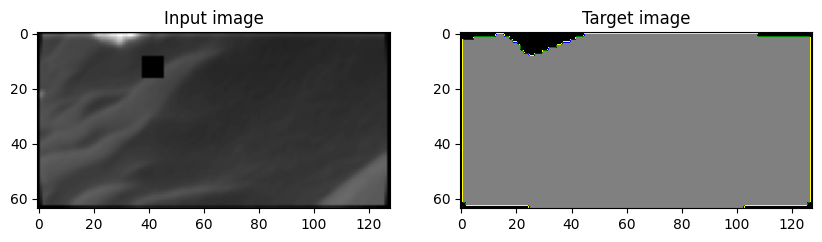

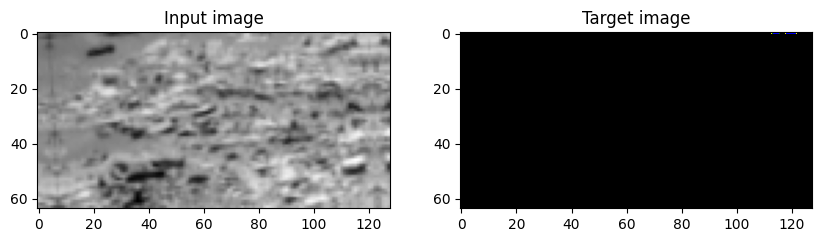

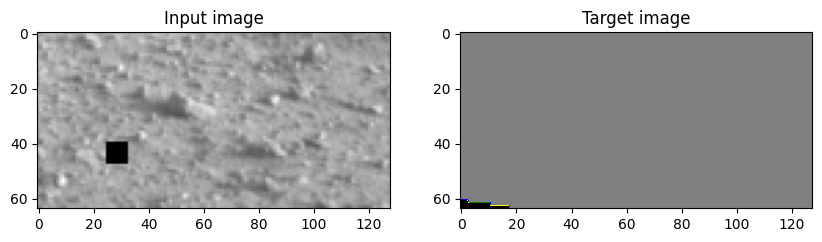

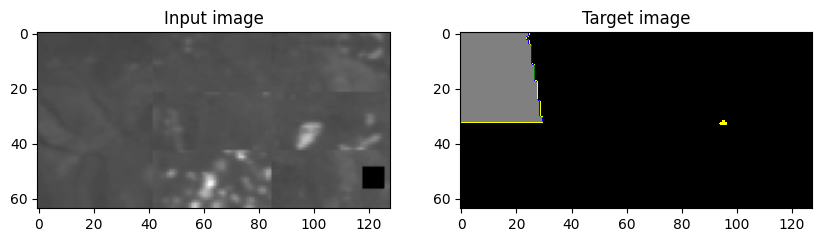

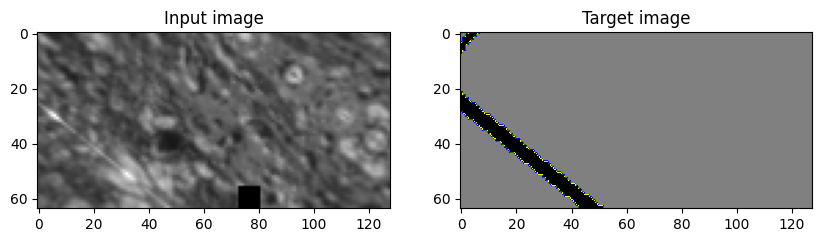

In [13]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [14]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [15]:
def aspp_block(x, filter_size, number_filters):
    """
    Atrous spatial pyramid pooling (ASPP)
    """
    y1 = tfkl.Conv2D(number_filters, (1, 1), kernel_initializer='lecun_uniform', padding='same', activation='relu', use_bias=False)(x)
    y2 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=6, padding='same', activation='relu', use_bias=False)(x)
    y3 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=12, padding='same', activation='relu', use_bias=False)(x)
    y4 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=18, padding='same', activation='relu', use_bias=False)(x)

    # Global Average Pooling
    # global_avg_pool = tfkl.GlobalAveragePooling2D()(x)
    # global_avg_pool = tfkl.Reshape((1, 1, tf.shape(global_avg_pool)[-1]))(global_avg_pool)
    # global_avg_pool = tfkl.Conv2D(number_filters, kernel_size=1, activation='relu', padding='same')(global_avg_pool)
    # global_avg_pool = tfkl.UpSampling2D(size=(tf.shape(x)[1], tf.shape(x)[2]), interpolation='bilinear')(global_avg_pool)

    concat = tfkl.Concatenate()([y1, y2, y3, y4])
    concat = tfkl.Conv2D(number_filters, (1, 1), padding='same', activation='relu')(concat)
    return concat

In [16]:
def Attention_ResUNet_with_aspp(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # downsample the input to match every downsampling made
    x_64 = tfkl.AveragePooling2D(pool_size=(2,2))(inputs)
    x_32 = tfkl.AveragePooling2D(pool_size=(4,4))(inputs)
    x_16 = tfkl.AveragePooling2D(pool_size=(8,8))(inputs)
    x_8 = tfkl.AveragePooling2D(pool_size=(16,16))(inputs)

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    conc_64 = tfkl.concatenate([pool_64, x_64], axis=axis)
    # DownRes 2
    conv_64 = res_conv_block(conc_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    conc_32 = tfkl.concatenate([pool_32, x_32], axis=axis)
    # DownRes 3
    conv_32 = res_conv_block(conc_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    conc_16 = tfkl.concatenate([pool_16, x_16], axis=axis)
    # DownRes 4
    conv_16 = res_conv_block(conc_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    conc_8 = tfkl.concatenate([pool_8, x_8], axis=axis)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(conc_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    aspp = aspp_block(conv_8, FILTER_SIZE, 16*FILTER_NUM)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(aspp)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    up_out = tfkl.UpSampling2D(size=(UP_SAMP_SIZE**(3), UP_SAMP_SIZE**(3)), data_format="channels_last")(up_conv_16)
    supervision_1 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_1')(up_out)

    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    up_out_2 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE**(2), UP_SAMP_SIZE**(2)), data_format="channels_last")(up_conv_32)
    supervision_2 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_2')(up_out_2)

    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    up_out_3 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    supervision_3 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_3')(up_out_3)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('softmax')(conv_final)

    # Model integration
    model = tfk.models.Model(inputs, outputs = [conv_final, supervision_3, supervision_2, supervision_1], name="AttentionResUNet_with_aspp_and_deep_supervision")
    return model


In [17]:
model = Attention_ResUNet_with_aspp()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


Model: "AttentionResUNet_with_aspp_and_deep_supervision"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 64)  │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 64)  │          128 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 64)  │          256 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 64)  │          256 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 64)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ average_pooling2d      │ (None, 32, 64, 1)    │            0 │ input_layer[0][0]   │    -    │
│ (AveragePooling2D)     │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate            │ (None, 32, 64, 65)   │            0 │ max_pooling2d[0][0… │    -    │
│ (Concatenate)          │                      │              │ average_pooling2d[… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 128)  │       75,008 │ concatenate[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3

 Total params: 72,668,524 (277.21 MB)

 Trainable params: 72,647,010 (277.13 MB)

 Non-trainable params: 21,514 (84.04 KB)

In [18]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [19]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            plt.close()

In [20]:
from keras import backend as K


def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    learning_rate = 0.5 * target_lr * (
    1 + tf.cos(
        tf.constant(np.pi, dtype=tf.float32) *
        (tf.cast(global_step, tf.float32) - tf.cast(warmup_steps, tf.float32) - tf.cast(hold, tf.float32)) /
        float(total_steps - warmup_steps - hold)
    )
    )


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(tfk.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )

In [21]:



def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Clip predictions to prevent log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    # Cross entropy loss
    cross_entropy_loss = -y_true * tf.math.log(y_pred)

    # Focal loss component
    focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy_loss
    return tf.reduce_sum(focal_loss, axis=-1)

# Dice Loss function
def dice_loss(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    dice = 1 - (2.0 * intersection + epsilon) / (union + epsilon)
    return tf.reduce_mean(dice)

# Combined Loss function
def combined_loss(y_true, y_pred, alpha=0.25, gamma=2.0, epsilon=1e-6):
    focal = focal_loss(y_true, y_pred, alpha, gamma)
    dice = dice_loss(y_true, y_pred, epsilon)
    return tf.reduce_mean(focal + dice)


@tf.function
def deep_supervision_loss(y_true, outputs, weights = [0.4, 0.3, 0.2, 0.1]):
    """
    Combine the final output loss and intermediate losses with weights.
    Args:
        y_true: Ground truth labels.
        outputs: List of outputs from model [final_output, supervision_1, supervision_2].
        weights: List of weights for each output.
    Returns:
        Combined loss.
    """

    losses = []

    for i in range(len(weights)):
        pred = outputs[i]
        # y_resized = tf.image.resize(y_true, [*pred.shape[0:2]])

        losses.append(weights[i] * combined_loss(y_true, pred))



    return tf.reduce_sum(losses)

# If batched
total_steps = len(train_dataset)*EPOCHS
# 5% of the steps
warmup_steps = int(0.08*total_steps)

lr_schedule = WarmUpCosineDecay(start_lr=0.0, target_lr=0.01, warmup_steps=warmup_steps, total_steps=total_steps, hold=warmup_steps)

print("Compiling model...")
model.compile(
    #loss=lambda y_true, y_pred: deep_supervision_loss(y_true, y_pred),
    #loss=combined_loss,
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        ],

    jit_compile=True,
    loss_weights=[1, 0.3, 0.2, 0.15],
    optimizer=tf.keras.optimizers.AdamW(lr_schedule),
    metrics=[ MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]), "accuracy", "accuracy", "accuracy"]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [22]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_activation_30_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_activation_30_mean_iou",
    factor=0.5,
    patience=30
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - activation_30_mean_iou: 0.1678 - loss: 1.5745

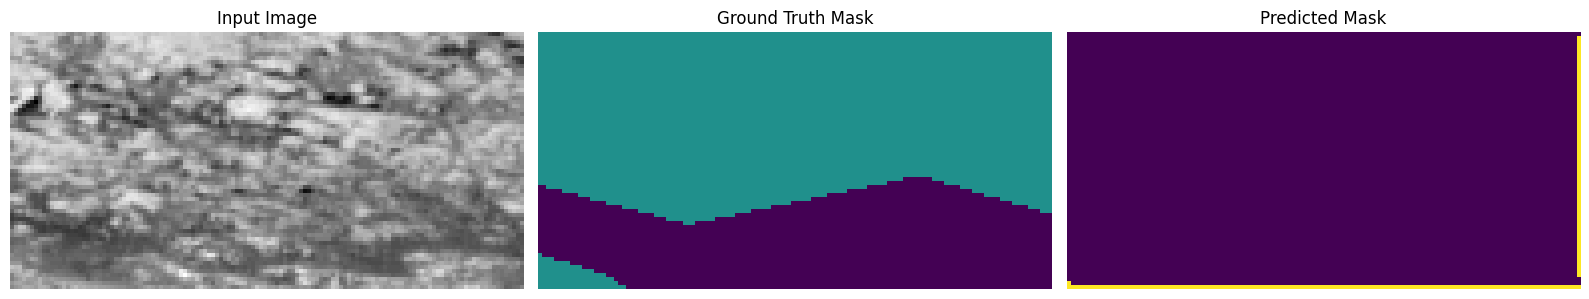

30/30 ━━━━━━━━━━━━━━━━━━━━ 753s 13s/step - activation_30_mean_iou: 0.1692 - loss: 1.5704 - val_activation_30_mean_iou: 6.9885e-04 - val_loss: 304.5409
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - activation_30_mean_iou: 0.2545 - loss: 1.2961 - val_activation_30_mean_iou: 4.4329e-04 - val_loss: 532.9580
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.2781 - loss: 1.2197 - val_activation_30_mean_iou: 0.0484 - val_loss: 48.4535
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.2887 - loss: 1.1737 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 200.2887
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.2938 - loss: 1.1339 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 83.1741
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3046 - loss: 1.1122

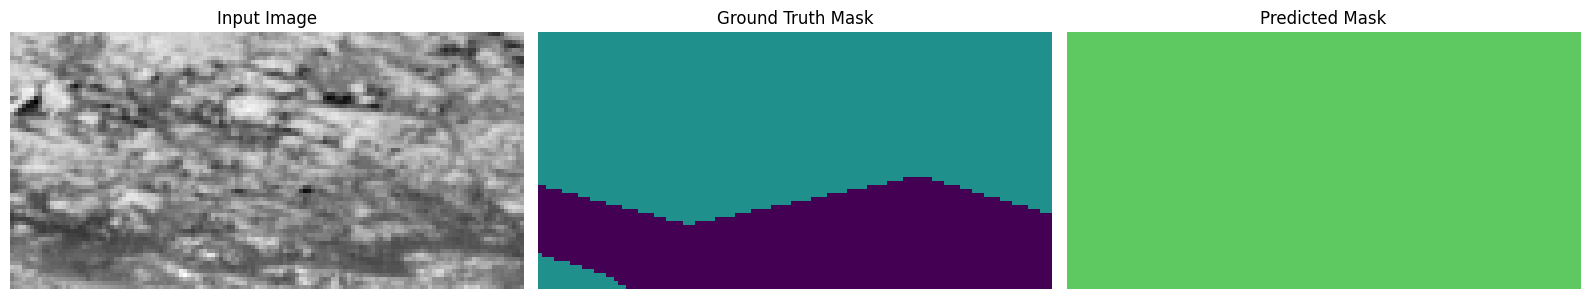

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3047 - loss: 1.1112 - val_activation_30_mean_iou: 0.1076 - val_loss: 8.5941
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.2871 - loss: 1.1101 - val_activation_30_mean_iou: 0.0523 - val_loss: 67.0380
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - activation_30_mean_iou: 0.3003 - loss: 1.0733 - val_activation_30_mean_iou: 0.1086 - val_loss: 28.9784
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - activation_30_mean_iou: 0.3340 - loss: 0.9923 - val_activation_30_mean_iou: 0.2453 - val_loss: 5.5158
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3644 - loss: 0.9445 - val_activation_30_mean_iou: 0.0568 - val_loss: 7.5124
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3336 - loss: 0.9727

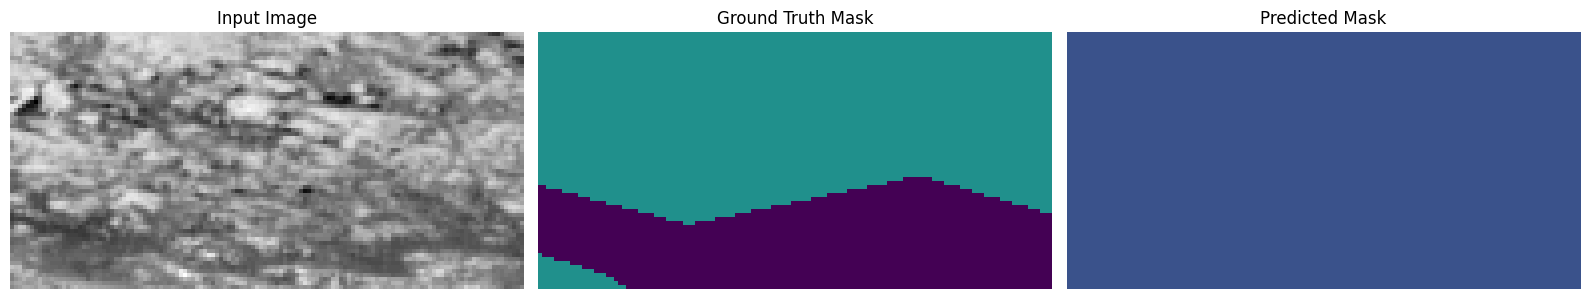

30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.3343 - loss: 0.9711 - val_activation_30_mean_iou: 0.0984 - val_loss: 7.5286
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.3395 - loss: 0.9207 - val_activation_30_mean_iou: 0.1135 - val_loss: 3.8122
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3597 - loss: 0.9078 - val_activation_30_mean_iou: 0.1895 - val_loss: 3.6160
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3545 - loss: 0.9099 - val_activation_30_mean_iou: 0.3582 - val_loss: 1.1728
Epoch 15/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.3567 - loss: 0.9029 - val_activation_30_mean_iou: 0.2337 - val_loss: 1.8046
Epoch 16/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3670 - loss: 0.8820

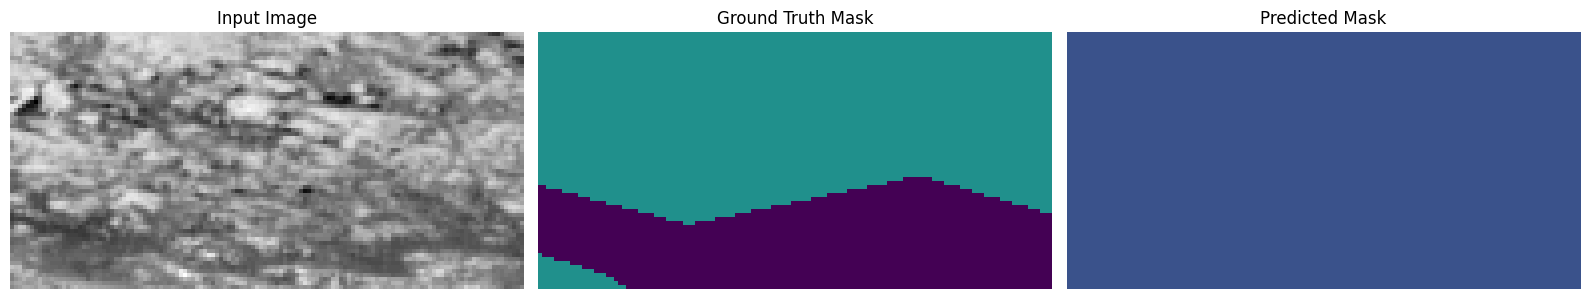

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3674 - loss: 0.8807 - val_activation_30_mean_iou: 0.2646 - val_loss: 1.8152
Epoch 17/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.3823 - loss: 0.8523 - val_activation_30_mean_iou: 0.3196 - val_loss: 1.4831
Epoch 18/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.3757 - loss: 0.8471 - val_activation_30_mean_iou: 0.2616 - val_loss: 2.4538
Epoch 19/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.3703 - loss: 0.8633 - val_activation_30_mean_iou: 0.0410 - val_loss: 5.6867
Epoch 20/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3823 - loss: 0.8480 - val_activation_30_mean_iou: 0.2840 - val_loss: 1.5589
Epoch 21/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3925 - loss: 0.8234

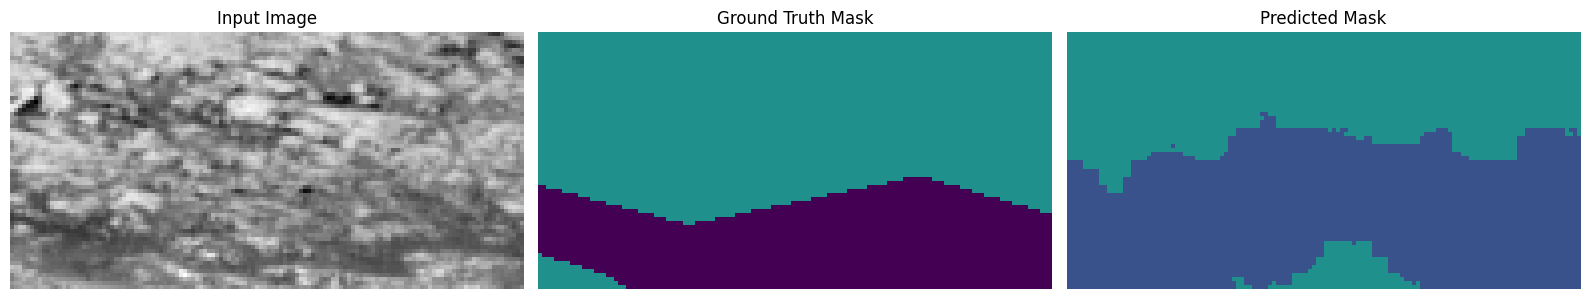

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.3926 - loss: 0.8227 - val_activation_30_mean_iou: 0.4206 - val_loss: 0.8508
Epoch 22/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - activation_30_mean_iou: 0.3955 - loss: 0.8202 - val_activation_30_mean_iou: 0.4128 - val_loss: 0.8341
Epoch 23/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3915 - loss: 0.8063 - val_activation_30_mean_iou: 0.2766 - val_loss: 1.6814
Epoch 24/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4093 - loss: 0.7934 - val_activation_30_mean_iou: 0.4027 - val_loss: 1.0379
Epoch 25/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3906 - loss: 0.7902 - val_activation_30_mean_iou: 0.3542 - val_loss: 0.9390
Epoch 26/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3883 - loss: 0.8071

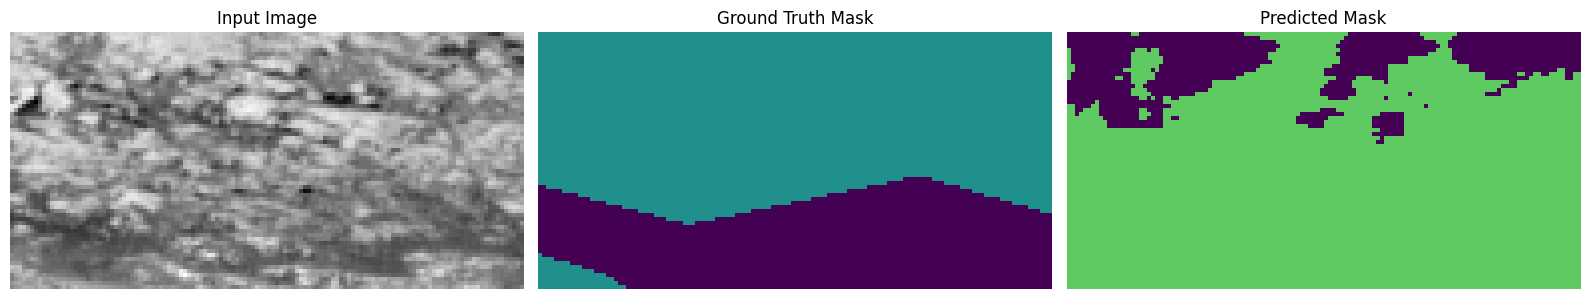

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.3887 - loss: 0.8061 - val_activation_30_mean_iou: 0.1542 - val_loss: 2.5205
Epoch 27/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.3949 - loss: 0.7902 - val_activation_30_mean_iou: 0.2226 - val_loss: 1.4826
Epoch 28/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4006 - loss: 0.7980 - val_activation_30_mean_iou: 0.1954 - val_loss: 1.7478
Epoch 29/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4157 - loss: 0.7612 - val_activation_30_mean_iou: 0.2953 - val_loss: 1.6103
Epoch 30/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4063 - loss: 0.7433 - val_activation_30_mean_iou: 0.3390 - val_loss: 1.1770
Epoch 31/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4068 - loss: 0.7541

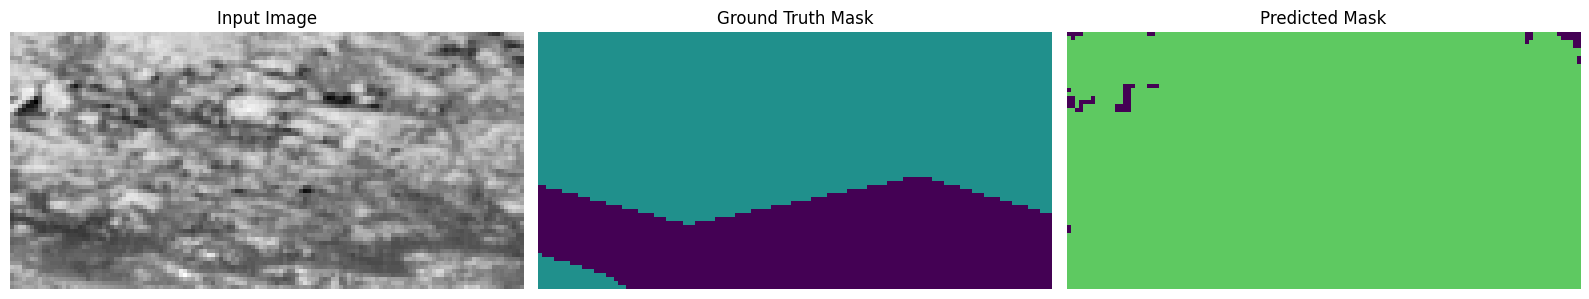

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4070 - loss: 0.7535 - val_activation_30_mean_iou: 0.1436 - val_loss: 1.9966
Epoch 32/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - activation_30_mean_iou: 0.4151 - loss: 0.7334 - val_activation_30_mean_iou: 0.3309 - val_loss: 1.0496
Epoch 33/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4069 - loss: 0.7438 - val_activation_30_mean_iou: 0.3953 - val_loss: 0.7936
Epoch 34/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4083 - loss: 0.7347 - val_activation_30_mean_iou: 0.3664 - val_loss: 1.0596
Epoch 35/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4183 - loss: 0.7447 - val_activation_30_mean_iou: 0.2580 - val_loss: 1.1436
Epoch 36/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4000 - loss: 0.7510

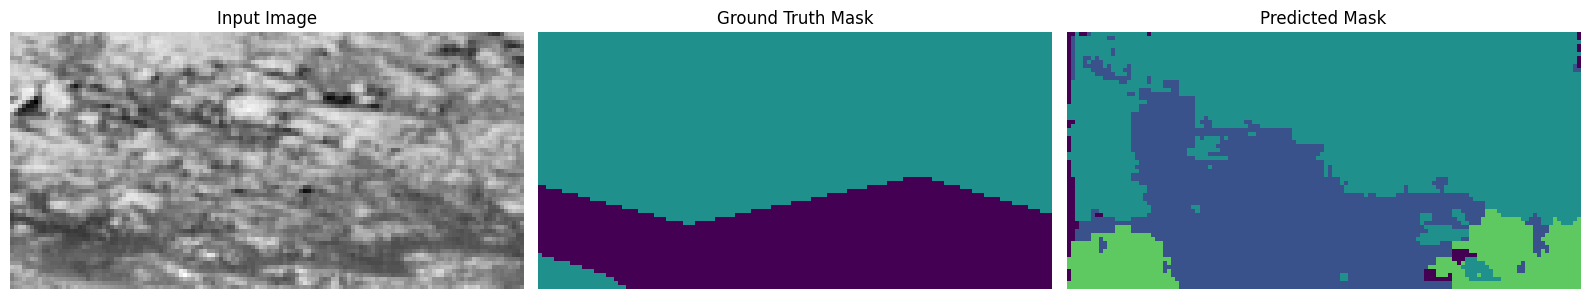

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4005 - loss: 0.7500 - val_activation_30_mean_iou: 0.3866 - val_loss: 0.8402
Epoch 37/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4214 - loss: 0.7180 - val_activation_30_mean_iou: 0.0909 - val_loss: 2.5817
Epoch 38/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4197 - loss: 0.7305 - val_activation_30_mean_iou: 0.3198 - val_loss: 1.0416
Epoch 39/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4236 - loss: 0.7058 - val_activation_30_mean_iou: 0.3292 - val_loss: 0.9804
Epoch 40/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4303 - loss: 0.6968 - val_activation_30_mean_iou: 0.4030 - val_loss: 0.8038
Epoch 41/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4291 - loss: 0.7010

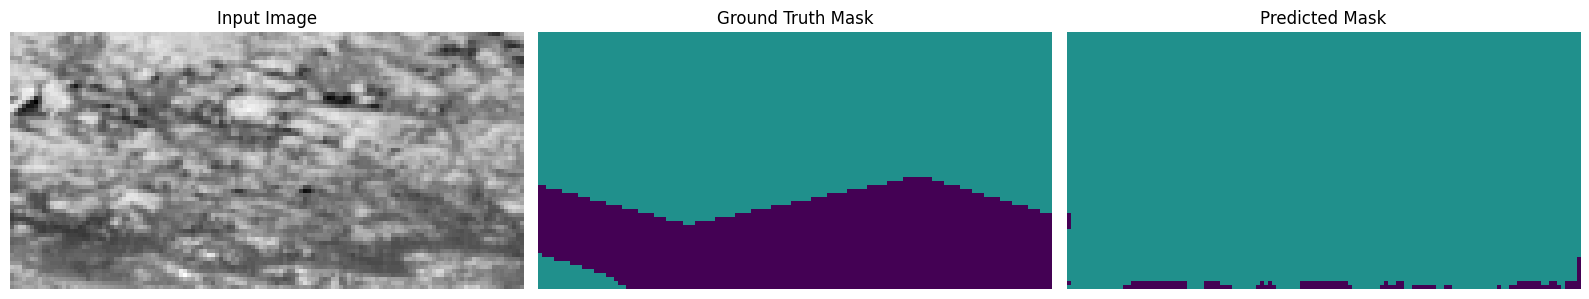

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4293 - loss: 0.7005 - val_activation_30_mean_iou: 0.3875 - val_loss: 0.7761
Final validation Mean Intersection Over Union: 42.06%


NotImplementedError: Learning rate schedule 'WarmUpCosineDecay' must override `get_config()` in order to be serializable.

In [23]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_activation_30_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
#del model

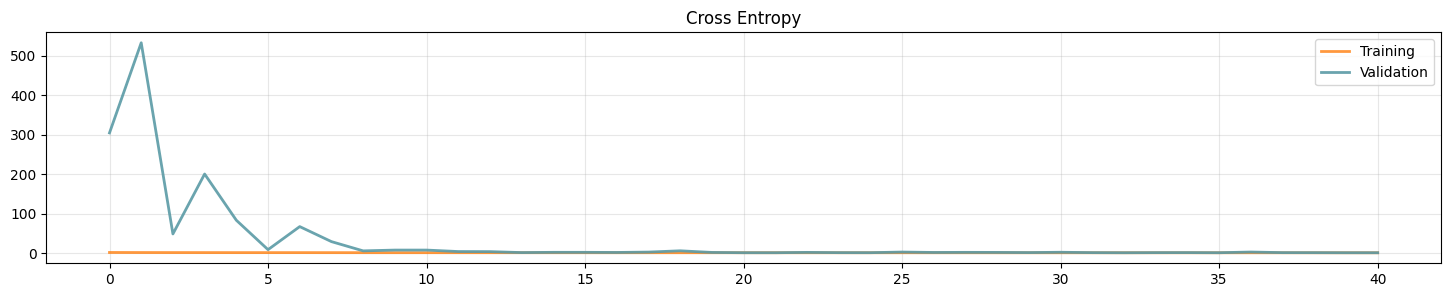

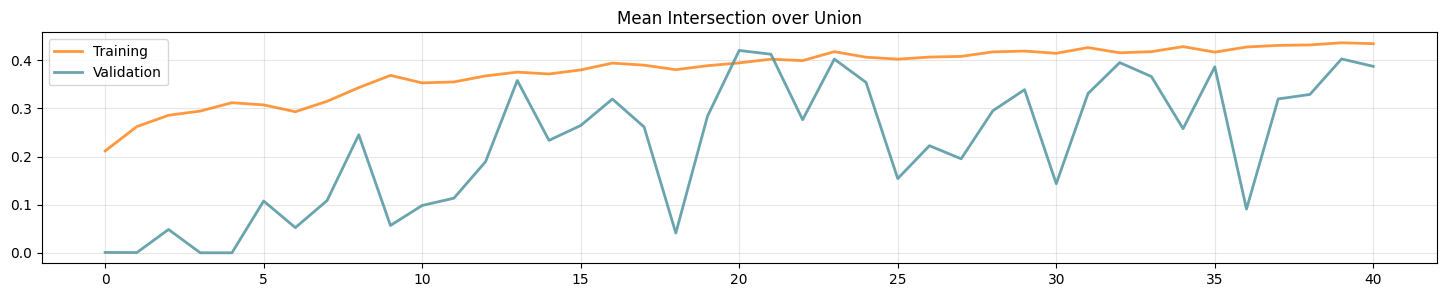

In [24]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
#plt.figure(figsize=(18, 3))
#plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
#plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
#plt.title('Accuracy')
#plt.legend()
#plt.grid(alpha=0.3)
#plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['activation_30_mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_activation_30_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [25]:
## If model_filename is not defined, load the most recent model from Google Drive
#if "model_filename" not in globals() or model_filename is None:
#    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#    if files:
#        model_filename = files[0]
#    else:
#        raise FileNotFoundError("No model files found in the current directory.")

In [26]:


#start_key = 586
#end_key = 10500  # Adjust this based on the expected range
#increment = 128
#
## Function to dynamically create custom_objects
#custom_objects = {
#    f'keras_tensor_{key}': repeat_elem
#    for key in range(start_key, end_key, increment)
#}
#
#
#model = tfk.models.load_model(model_filename, compile=False, safe_mode=False, custom_objects=custom_objects)
print(f"Model loaded from {model_filename}")

Model loaded from model_UNet_42.06.keras


In [38]:
preds = model.predict(test_dataset)
preds = np.argmax(preds[0], axis=-1)
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(test_lbl[i])
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-09bd8a546826>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

Out of memory while trying to allocate 1140176128 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_571032]

In [37]:
print(X_test.shape)
preds = model.predict(X_test)

first_output_with_tf_slice = tf.slice(preds, [0, 0], [1, -1])  # Extract first row, keeping dimensions
first_output_with_tf_slice = tf.squeeze(first_output_with_tf_slice, axis=0)  # Remove batch dimension

# concate every out

preds = np.argmax(first_output_with_tf_slice, axis=-1)

for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  print(preds.shape)
  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


(10022, 64, 128, 1)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

In [ ]:
## disconnect time
from google.colab import runtime
runtime.unassign()

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```